In [122]:
import pysheds.grid
import geopandas
import pandas
import pathlib
import numpy
import rioxarray
import matplotlib
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [139]:
cache_dir = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\Westport\caches\high_reso")
dem_file = cache_dir / "2m_ground_water_dem.nc"
catchment_file = pathlib.Path(r'C:\Users\pearsonra\Documents\data\Westport\catchments\high_reso.geojson')
with rioxarray.rioxarray.open_rasterio(dem_file, masked=True) as dem:
    dem.load()
dem = dem.copy(deep=True)
catchment = geopandas.read_file(catchment_file)
catchment = catchment.to_crs(2193)

In [141]:
dem = dem.rio.interpolate_na(method='linear')
dem = dem.rio.clip(catchment.geometry)
dem.to_netcdf(cache_dir / "2m_ground_water_dem_no_nan.nc")

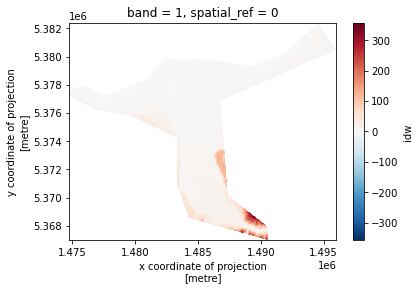

In [142]:
dem.plot()

### Interpolate missing values

In [111]:
cache_dir = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\100000000")
dem_file = cache_dir / "channel_dem_50m.nc"
catchment_file = cache_dir / "channel_catchment_100000000.geojson"
dem_nan_file = cache_dir / "channel_dem_50_nan.nc"
with rioxarray.rioxarray.open_rasterio(dem_file, masked=True) as dem:
    dem.load()
dem = dem.copy(deep=True)
catchment = geopandas.read_file(catchment_file)

### linear interpolation of nan values

In [112]:
dem = dem.rio.interpolate_na(method='linear')
dem = dem.rio.clip(catchment.geometry)
dem.to_netcdf(dem_nan_file)

In [113]:
#dem.rio.to_raster(cache_dir / "channel_dem_100000000_nan.tif")

## Pysheds

In [114]:
grid = pysheds.grid.Grid.from_raster(str(dem_file))
dem = grid.read_raster(str(dem_file))

### First conditioning

In [115]:
# detect
pits = grid.detect_pits(dem)
print(f"There are {pits.sum()}")
# Fill
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
print(f"And only {pits.sum()} after filling")
#assert not pits.any()

There are 58
And only 0 after filling


In [116]:
# detect
depressions = grid.detect_depressions(pit_filled_dem)
print(f"There are {depressions.sum()}")
# Fill
flooded_dem = grid.fill_depressions(pit_filled_dem)
m = grid.detect_depressions(flooded_dem)
print(f"And only {depressions.sum()} after filling")
#assert not depressions.any()

There are 167
And only 167 after filling


In [117]:
# detect
flats = grid.detect_flats(flooded_dem)
print(f"There are {flats.sum()}")
# Fill
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)
print(f"And only {flats.sum()} after filling")
#assert not flats.any()

There are 7597
And only 7404 after filling


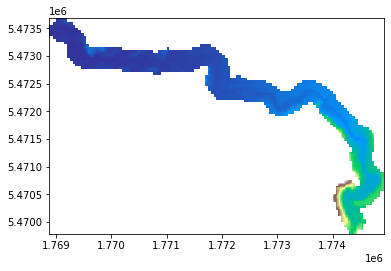

In [118]:
matplotlib.pyplot.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)

### Resolve flats and copmute flow directions

In [119]:
inflated_dem = grid.resolve_flats(dem)
fdir = grid.flowdir(inflated_dem)

In [120]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
acc = grid.accumulation(fdir, dirmap=dirmap)

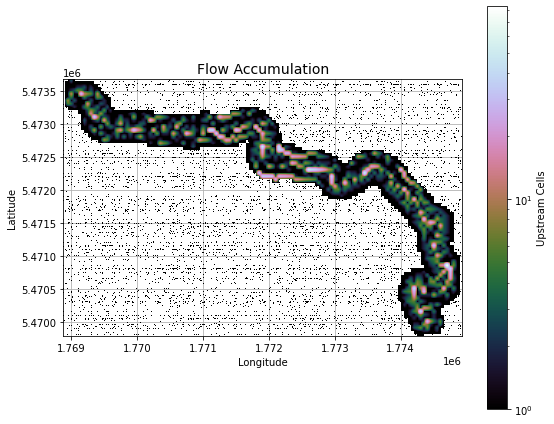

In [121]:
fig, ax = matplotlib.pyplot.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
matplotlib.pyplot.grid('on', zorder=0)
im = matplotlib.pyplot.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=matplotlib.colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
matplotlib.pyplot.colorbar(im, ax=ax, label='Upstream Cells')
matplotlib.pyplot.title('Flow Accumulation', size=14)
matplotlib.pyplot.xlabel('Longitude')
matplotlib.pyplot.ylabel('Latitude')
matplotlib.pyplot.tight_layout()

In [65]:
acc

Raster([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
branches = grid.extract_river_network(fdir, acc > 1000)

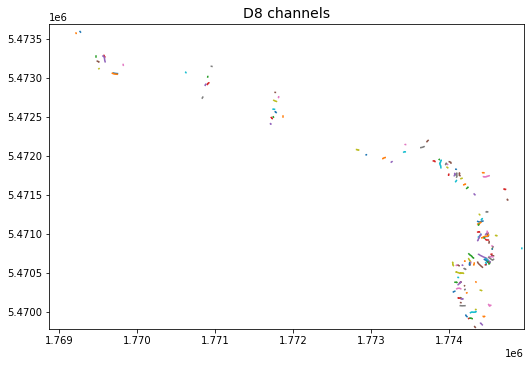

In [75]:
fig, ax = matplotlib.pyplot.subplots(figsize=(8.5,6.5))

matplotlib.pyplot.xlim(grid.bbox[0], grid.bbox[2])
matplotlib.pyplot.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = numpy.asarray(branch['geometry']['coordinates'])
    matplotlib.pyplot.plot(line[:, 0], line[:, 1])
    
_ =  matplotlib.pyplot.title('D8 channels', size=14)